# Importing modules

In [3825]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox

pd.options.display.max_rows = 50

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder  ##. better to use dummy from pandas 
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

## Data Cleaning

### loading & exploring Data

In [3826]:
re_df = pd.read_excel('Data_MidTerm_Project_Real_State_Regression.xls')

In [3827]:
re_df.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [3828]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   waterfront     21597 non-null  int64         
 8   view           21597 non-null  int64         
 9   condition      21597 non-null  int64         
 10  grade          21597 non-null  int64         
 11  sqft_above     21597 non-null  int64         
 12  sqft_basement  21597 non-null  int64         
 13  yr_built       21597 non-null  int64         
 14  yr_renovated   21597 non-null  int64         
 15  zipcode        2159

In [3829]:
re_df['date'] = re_df['date'].dt.to_period('M')

In [3830]:
re_df['date'] = re_df['date'].dt.strftime('%m/%Y')

In [3831]:
re_df['date'].value_counts()

04/2015    2229
07/2014    2211
06/2014    2178
08/2014    1939
10/2014    1876
03/2015    1875
09/2014    1771
05/2014    1768
12/2014    1470
11/2014    1409
02/2015    1247
01/2015     978
05/2015     646
Name: date, dtype: int64

In [3832]:
#re_df = re_df[re_df.date != "05/2015"]
#re_df = re_df[re_df.date != "01/2015"]

### droping columns

In [3833]:
re_df.drop(['id'],axis=1, inplace=True)
#re_df.drop(['view'],axis=1, inplace=True)
re_df.drop(['yr_renovated'],axis=1, inplace=True)
re_df.drop(['sqft_above'],axis=1, inplace=True)
#re_df.drop(['long'],axis=1, inplace=True)
#re_df.drop(['lat'],axis=1, inplace=True)
#re_df.drop(['zipcode'],axis=1, inplace=True)
re_df.drop(['sqft_lot'],axis=1, inplace=True)

### creating a new column area

In [3834]:
area = []

for row in re_df['price']:
    if row < 300000:
        area.append('affordable area')
    elif row >= 300000 and row < 600000:
        area.append('medium priced area')
    elif row >= 600000 and row < 900000:
        area.append('expensive area')
    elif row >= 900000:  
        area.append('very expensive area')
    else:         
        area.append('Not_Rated')
        
re_df['area'] = area

#step 1: zipcodes gruppieren und avg price ausgeben lassen
#step 2: gruppen sortieren nach avg price
    
grouped_zipcodes = re_df.groupby("zipcode")[["price"]].mean().sort_values(by="price", ascending=False)

#step 3: schwellwerte festlegen

affordable_area =list(grouped_zipcodes[grouped_zipcodes["price"]< 400000].index)
medium_priced_area = list(grouped_zipcodes[(grouped_zipcodes["price"]>= 400000) & (grouped_zipcodes["price"]< 800000)].index)
expensive_area =list(grouped_zipcodes[grouped_zipcodes["price"]>=800000].index)


#step 4: neue column erstellen mit zip code gruppen

area = []

for row in re_df['zipcode']:
    if row in affordable_area:
        area.append('affordable area')
    elif row in medium_priced_area:
        area.append('medium priced area')
    elif row in expensive_area:
        area.append('expensive area')

re_df['area'] = area 



### removing duplicates

In [3835]:
re_df.drop_duplicates(inplace=True)

### droping nan values

In [3836]:
#re_df.view.hist()
#re_df.dropna(inplace=True)
#re_df

### renaming waterfront column features

In [3837]:
def clean_waterfront(x):
    if x == 0:
        return 'no'
    elif x == 1:
        return 'yes'

In [3838]:
re_df["waterfront"] = list(map(clean_waterfront,re_df["waterfront"])) 

### removing outliers

#### bedrooms

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms'>

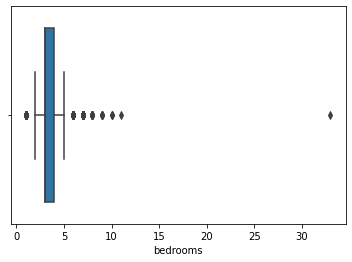

In [3839]:
sns.boxplot(re_df['bedrooms'])

In [3840]:
max(re_df['bedrooms'])

33

In [3841]:
#re_df = re_df[re_df.bedrooms != max(re_df['bedrooms'])]

re_df.loc[re_df['bedrooms'] == 33]

,date,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price,area
15856,06/2014,33,1.75,1620,1.0,no,0,5,7,580,1947,98103,47.6878,-122.331,1330,4700,640000,expensive area


Based on the sqft_living we asume that there is typing error

In [3842]:
re_df.at[15856,'bedrooms'] = 3

#### bathrooms

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bathrooms'>

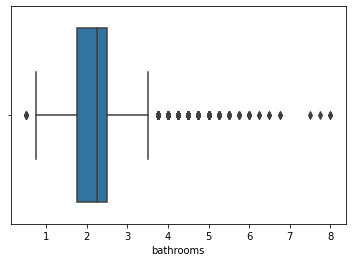

In [3843]:
sns.boxplot(re_df['bathrooms'])

In [3844]:
re_df['bathrooms'].value_counts()

re_df = re_df[re_df.bathrooms != max(re_df['bathrooms'])]
#re_df = re_df[re_df.bathrooms != 7.75]

#### sqft_lot

sns.boxplot(re_df['sqft_lot'])

max(re_df['sqft_lot'])

re_df.loc[re_df['sqft_lot'] == 1651359]

re_df.at[1717,'sqft_lot'] = 16513.59

#### price

In [3845]:
re_df = re_df[re_df['price'] < 4000000]

## Plot the Correlation Heatmap

re_num = re_df[['sqft_living','sqft_lot','sqft_living15','sqft_lot15','sqft_basement']]

corr = re_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Split Data into groups

expensive_zipcodes= [98199, 98119, 98109, 98102, 98105, 98112, 98033, 98039, 98004, 98005, 98040, 98006, 98075]
expensive_areas = re_df[re_df['zipcode'].isin(expensive_zipcodes)]

affordable_areas = re_df[~re_df['zipcode'].isin(expensive_zipcodes)]

## X Y split

In [3846]:
X=re_df.drop("price", axis=1)
y=re_df["price"]

## Data Splitting

In [3847]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

In [3848]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Data Transformation

### Hot coding Categorical Variables

In [3849]:
X_train_cat=X_train[['date','bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','zipcode','lat','long','area']]
X_train_cat

X_test_cat=X_test[['date','bedrooms','bathrooms','view','floors','waterfront','condition','grade','yr_built','zipcode','lat','long','area']]
X_test_cat

,date,bedrooms,bathrooms,view,floors,waterfront,condition,grade,yr_built,zipcode,lat,long,area
18817,06/2014,3,2.25,0,2.0,no,4,9,1964,98005,47.6482,-122.159,expensive area
7292,06/2014,3,1.00,0,1.5,no,3,7,1901,98117,47.6865,-122.397,affordable area
21143,04/2015,3,2.50,0,2.0,no,3,7,2008,98126,47.5730,-122.372,medium priced area
4224,11/2014,2,2.50,0,2.0,no,3,8,1994,98199,47.6375,-122.387,medium priced area
5067,07/2014,3,2.50,0,1.0,no,3,8,1953,98136,47.5245,-122.384,expensive area
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1658,12/2014,8,5.00,0,2.0,no,3,8,1997,98122,47.6086,-122.303,medium priced area
18441,09/2014,3,1.50,0,1.0,no,5,7,1957,98022,47.2012,-122.000,affordable area
5714,09/2014,3,3.00,0,1.0,no,4,10,1979,98092,47.3080,-122.087,medium priced area
10233,06/2014,3,1.50,2,2.0,no,5,8,1913,98109,47.6333,-122.347,very expensive area


In [3850]:
X_train_cat=pd.get_dummies(X_train_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_train_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_train_cat).get_feature_names(input_features=X_train_cat.columns))

X_test_cat=pd.get_dummies(X_test_cat, drop_first=True)
pd.DataFrame(OneHotEncoder(drop='first').fit_transform(X_test_cat).toarray(),
columns=OneHotEncoder(drop='first').fit(X_test_cat).get_feature_names(input_features=X_test_cat.columns))

,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bathrooms_0.75,...,date_07/2014_1,date_08/2014_1,date_09/2014_1,date_10/2014_1,date_11/2014_1,date_12/2014_1,waterfront_yes_1,area_expensive area_1,area_medium priced area_1,area_very expensive area_1
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6470,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6471,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6472,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3851]:
X_train_cat = X_train_cat.reset_index(drop=True)
X_test_cat = X_test_cat.reset_index(drop=True)

### Standardize numerical

In [3852]:
X_train_num=X_train[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_train_num

X_test_num=X_test[['sqft_living','sqft_living15','sqft_lot15','sqft_basement']]
X_test_num

,sqft_living,sqft_living15,sqft_lot15,sqft_basement
18817,2120,3280,50690,0
7292,1210,1450,5264,0
21143,2040,1410,2500,570
4224,1590,1880,3675,290
5067,2060,1990,7560,900
...,...,...,...,...
1658,2800,1800,2580,920
18441,1550,1450,9282,0
5714,3760,2820,50543,1120
10233,2680,2280,5947,800


In [3853]:
std_scaler=StandardScaler().fit(X_train_num)   ## finding the parameters (mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train_num)

In [3854]:
X_test_scaled=std_scaler.transform(X_test_num)

In [3855]:
print(X_train_scaled)
print("--------")
print(X_test_scaled)

[[-1.40372681 -0.24294311 -0.18624028 -0.65841898]
 [-0.60713213 -0.63755096  0.02981337  0.13587085]
 [-1.3262801  -0.90062286 -0.27581381 -0.65841898]
 ...
 [ 0.36648358 -0.15525248 -0.23446106  1.38404059]
 [-0.39691965 -1.29523071 -0.2555712   1.29326461]
 [-1.19351432 -0.82754733 -0.41765663 -0.49956102]]
--------
[[ 0.04563294  1.8908623   1.37175343 -0.65841898]
 [-0.96117421 -0.78370202 -0.27028324 -0.65841898]
 [-0.04287757 -0.84216244 -0.37019495  0.63513874]
 ...
 [ 1.86009859  1.21856744  1.36643975  1.88330848]
 [ 0.66520658  0.42935174 -0.24559449  1.15710063]
 [ 0.36648358  1.61317529 -0.03033608  1.17979463]]


In [3856]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train_num.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test_num.columns)

In [3857]:
X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)

### Quantile Transformer

In [3858]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_living15'] = qt.transform(X_train_scaled['sqft_living15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_living15'] = qt.transform(X_test_scaled['sqft_living15'].to_numpy().reshape(-1,1))

In [3859]:
qt = QuantileTransformer(output_distribution="normal").fit(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_train_scaled['sqft_lot15'] = qt.transform(X_train_scaled['sqft_lot15'].to_numpy().reshape(-1,1))
X_test_scaled['sqft_lot15'] = qt.transform(X_test_scaled['sqft_lot15'].to_numpy().reshape(-1,1))

pt = PowerTransformer().fit(y_train.to_numpy().reshape(-1,1))
y_train = pt.transform(y_train.to_numpy().reshape(-1,1))
y_test = pt.transform(y_test.to_numpy().reshape(-1,1))

## Concatination 

In [3860]:
X_train_con=pd.concat([X_train_scaled,X_train_cat],axis=1)
X_test_con=pd.concat([X_test_scaled,X_test_cat],axis=1)

In [3861]:
X_train_con

,sqft_living,sqft_living15,sqft_lot15,sqft_basement,bedrooms,bathrooms,view,floors,condition,grade,...,date_07/2014,date_08/2014,date_09/2014,date_10/2014,date_11/2014,date_12/2014,waterfront_yes,area_expensive area,area_medium priced area,area_very expensive area
0,-1.403727,-0.031369,-0.009361,-0.658419,3,1.00,0,1.0,3,7,...,1,0,0,0,0,0,0,0,1,0
1,-0.607132,-0.527858,1.071514,0.135871,3,1.75,0,1.0,3,7,...,0,0,0,0,1,0,0,0,1,0
2,-1.326280,-0.959440,-0.665254,-0.658419,2,1.00,0,1.0,3,6,...,0,0,0,0,0,1,0,0,1,0
3,-0.651387,-0.840906,-0.103524,0.249341,3,1.50,0,1.0,3,7,...,0,0,0,0,0,1,0,0,1,0
4,-0.883728,-0.361511,-0.748009,-0.658419,3,1.00,0,1.0,3,6,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15100,1.196270,2.256745,0.935725,1.610981,3,2.50,3,1.0,3,11,...,0,0,1,0,0,0,0,0,0,1
15101,1.174142,1.097845,0.837234,-0.658419,4,2.50,0,2.0,3,10,...,0,0,0,0,1,0,0,0,0,1
15102,0.366484,0.060256,-0.341141,1.384041,4,1.00,0,1.0,3,7,...,0,0,0,0,1,0,0,0,1,0
15103,-0.396920,-1.756055,-0.510755,1.293265,4,2.00,0,1.0,4,7,...,0,1,0,0,0,0,0,0,1,0


##  Apply Linear Regression

### Modelling using Statsmodels

In [3862]:
X_train_const_scaled = sm.add_constant(X_train_con) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_con) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     2305.
Date:                Tue, 08 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:44:00   Log-Likelihood:            -2.0132e+05
No. Observations:               15105   AIC:                         4.027e+05
Df Residuals:                   15074   BIC:                         4.029e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/Users/louisarudow/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [3863]:
predictions_test

0       7.304141e+05
1       3.783844e+05
2       4.063520e+05
3       4.281317e+05
4       6.398892e+05
            ...     
6469    4.853812e+05
6470    2.136252e+05
6471    6.070248e+05
6472    1.274193e+06
6473    5.344531e+05
Length: 6474, dtype: float64

In [3864]:
#display adjusted R-squared
print(model.rsquared_adj)

0.820680401892463


### Modeling using Scikit Learn

In [3865]:
model=LinearRegression()    # model
model.fit(X_train_con, y_train)   # model train

LinearRegression()

In [3866]:
model.coef_

array([ 8.58620775e+04,  1.49452247e+03, -1.56398908e+04, -7.82209429e+03,
       -1.80562131e+04,  2.13854317e+04,  2.21393049e+04, -1.26797828e+04,
        1.36604593e+04,  4.58144970e+04, -1.28174697e+03, -3.54621742e+02,
        3.24679700e+05, -6.88015320e+04, -3.69292299e+03,  3.41443279e+03,
        8.32856038e+03, -1.23208102e+04,  2.38164170e+04, -1.07033354e+04,
       -8.47781385e+03, -1.09761170e+04, -1.20773797e+04, -9.61861302e+03,
       -6.95817396e+03, -1.09355623e+04,  4.67670346e+05,  2.44942293e+05,
        7.86299852e+04,  6.82433617e+05])

In [3867]:
model.intercept_

13475264.653534148

Making prediction

In [3868]:
y_pred=model.predict(X_test_con)   # model prediction
##y_pred_train=model.predict(X_train_scaled)

In [3869]:
y_test

0        835000
1        285000
2        494900
3        509500
4        731100
         ...   
6469     490000
6470     245000
6471     555000
6472    1360000
6473     490000
Name: price, Length: 6474, dtype: int64

In [3870]:
y_pred

array([ 730414.07014924,  378384.37377668,  406352.01451817, ...,
        607024.77065746, 1274192.72730692,  534453.05789541])

In [3871]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result

,y_test,y_pred
0,835000,7.304141e+05
1,285000,3.783844e+05
2,494900,4.063520e+05
3,509500,4.281317e+05
4,731100,6.398892e+05
...,...,...
6469,490000,4.853812e+05
6470,245000,2.136252e+05
6471,555000,6.070248e+05
6472,1360000,1.274193e+06


Linear Regression Train-test split. Standardize the data (after the data split). Apply linear regression. Model Interpretation. Model Validation Model Evaluation: MSE. RMSE. MAE. R2. Adjusted R2. Feature Importance.

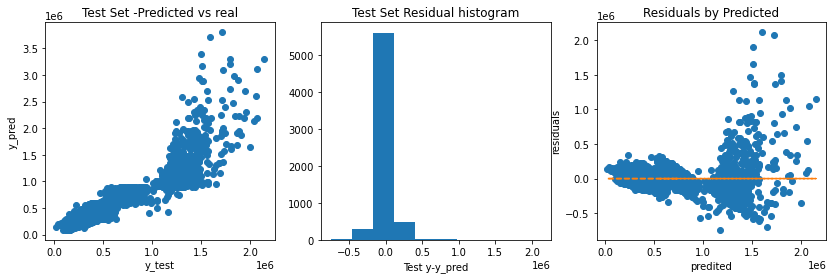

In [3872]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

#### Error metrics

In [3873]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

19828930114.286804
80252.57684596705


In [3874]:
R2=r2_score(y_test,y_pred)
R2

0.828428886983854

In [3875]:
X_test.shape[1]

17

In [3876]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.8279771043132724

#### Feature Importance

In [3877]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train_con.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance')

In [3878]:
features_importances

,Attribute,Importance
11,zipcode,354.621742
10,yr_built,1281.746973
1,sqft_living15,1494.522472
15,date_03/2015,3414.432792
14,date_02/2015,3692.922995
24,date_11/2014,6958.173956
3,sqft_basement,7822.094286
16,date_04/2015,8328.560381
20,date_07/2014,8477.813851
23,date_10/2014,9618.613021


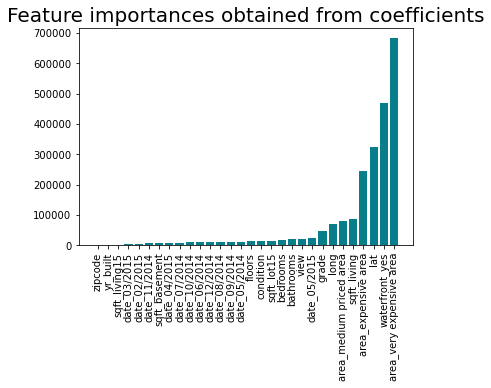

In [3879]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

#### Evaluating predictions

In [3880]:
# MAE: mean absolute error
MAE = np.mean( np.abs( y_test - y_pred ) )
MAE

80252.57684596698

In [3881]:
# MSE: mean squared error
MSE = np.mean( np.power( y_test - y_pred , 2 ) )
MSE

19828930114.286804

In [3882]:
# RMSE: root mean squared error
RMSE = np.sqrt(MSE)
RMSE

140815.2339567236

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_basement'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>],
       [<AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>,
        <AxesSubplot:title={'center':'price'}>, <AxesSubplot:>]],
      dtype=object)

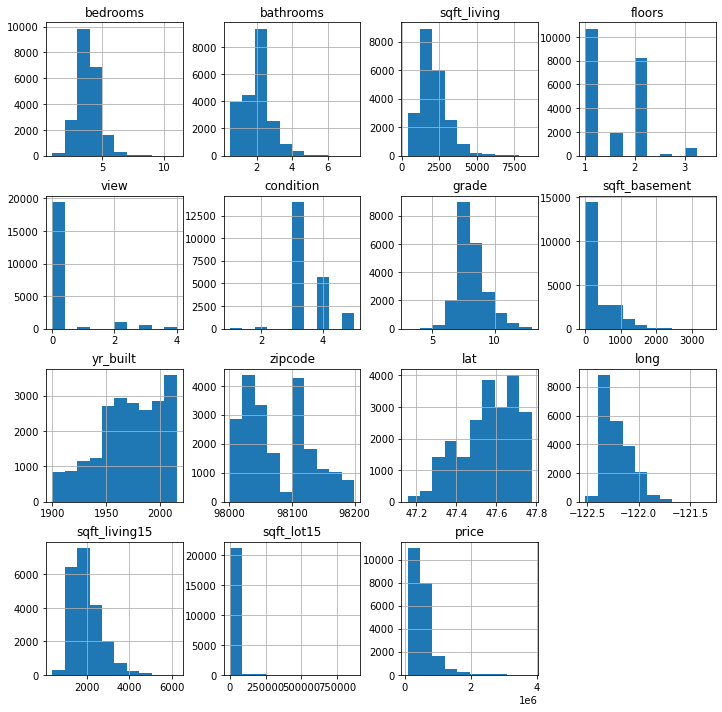

In [3883]:
re_df.hist(figsize=(12,12))